In [1]:
#
# In this notebook, we use fastai to classify images of skin lesions as (i) benign or
# malignent and (ii) melanocytic or keratinoctyic, corresponding to Part 3 of the 2017
# ISIC Challenge (see https://arxiv.org/pdf/1710.05006.pdf for a review of the challenge
# and its results). See also README.md for a description of the course assignment and
# pointers to the data.

# We obtain here the following ROC AUC scores:
#   (i) 0.84
#   (ii) 0.93,
# placing this model in ~5th for the 2017 ISIC competition.

# We could improve this model by using additional data sources or by building multiple
# models and stacking the models' predictions together, as done by the winners of the 
# competition. We could also potentially benefit from some data quality control. But 
# such are optimizations are beyond the intended scope here.
#

In [2]:
import torch
from fastai import *
from fastai.vision import *
from get_results import plot_roc_auc, predict_all

# Training parameters

In [7]:
# gpu or cpu
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device {device}.')
    
# random seed (randomness in DataLoader)
torch.random.manual_seed(1234)

# batch size
bs = 64

Using device cuda.


# DataLoader

In [9]:
# DataLoader for image data
# assumes the data is stored in ImageNet style structure {train,valid}/label/image
# set num_workers to no more than the number of CPU cores on your machine
# bs should be a power of 2 and as large as possible without exceeding GPU memory
data = ImageDataBunch.from_folder(
    path = '/data',
    ds_tfms = get_transforms(flip_vert=True),
    device = device, 
    size = 224, bs = bs, num_workers = 32
)

# For pre-trained data, need to normalize to ImageNet stats
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
melanoma,melanoma,melanoma,melanoma,melanoma
Path: /data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
melanoma,melanoma,melanoma,melanoma,melanoma
Path: /data;

Test: None

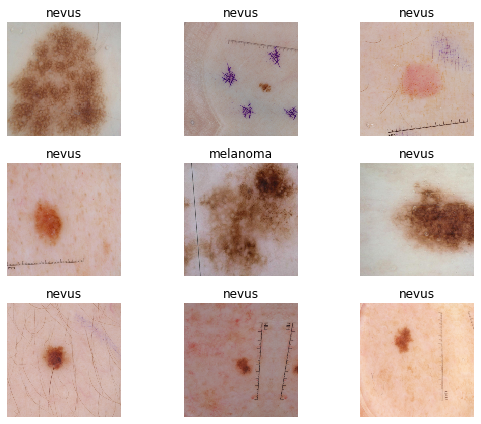

In [10]:
data.show_batch(rows=3, figsize=(8,6))

# Transfer Learning: ResNet101

In [22]:
learn101 = cnn_learner(data, models.resnet101, metrics=error_rate)

In [13]:
# callback to save model at end of epoch
every_cb = callbacks.SaveModelCallback(learn101, every='epoch', monitor='accuracy', name='resnet101_stage1')

# train model for 10 cycles
learn101.fit_one_cycle(10, callbacks=[every_cb])

epoch,train_loss,valid_loss,error_rate,time
0,1.734428,1.018097,0.366667,01:33
1,1.526239,1.031656,0.360000,01:36
2,1.216360,0.812691,0.293333,01:32
3,0.967621,0.740479,0.280000,01:34
4,0.816968,0.584112,0.186667,01:33
5,0.693698,0.650928,0.220000,01:35
6,0.622469,0.609175,0.226667,01:33
7,0.566260,0.603739,0.240000,01:32
8,0.525950,0.586161,0.213333,01:33
9,0.493120,0.572297,0.200000,01:34


/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `accuracy` which is not available. Available metrics are: train_loss, valid_loss, error_rate
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


In [27]:
# load best model and set all parameters trainable
learn101 = learn101.load('resnet101_stage1_9')
learn101.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


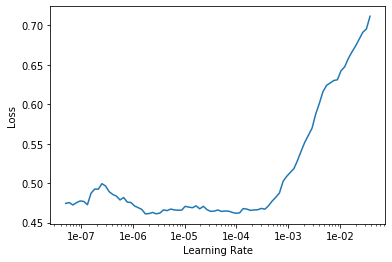

In [28]:
# find good learning rate
learn101.lr_find(start_lr=1e-8, end_lr=1e-1)
learn101.recorder.plot()

In [29]:
#
# The learning rate curve above indicates we are already pretty close to a local 
# minimum since the best improvement in the loss is pretty close to the improvement
# in the loss at almost zero learning rate. We shouldn't expect to see any more 
# huge gains in the loss.
#
every_cb = callbacks.SaveModelCallback(learn101, every='epoch', monitor='accuracy', name='resnet101_stage2')
learn101.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4), callbacks=[every_cb])

epoch,train_loss,valid_loss,error_rate,time
0,0.463826,0.579070,0.200000,01:39
1,0.454820,0.563218,0.206667,01:41
2,0.442808,0.548480,0.220000,01:40
3,0.430799,0.554058,0.213333,01:39
4,0.413101,0.540636,0.213333,01:35
5,0.400431,0.539084,0.193333,01:36
6,0.383481,0.540655,0.200000,01:39
7,0.369076,0.519716,0.193333,01:37
8,0.357832,0.517811,0.200000,01:40
9,0.342530,0.520999,0.180000,01:36


# ResNet101 Results

In [32]:
# get predictions on test set
learn101 = learn101.load('resnet101_stage2_9')
labels, predictions = predict_all(learn101, output='resnet101_predictions.csv', silent=True)

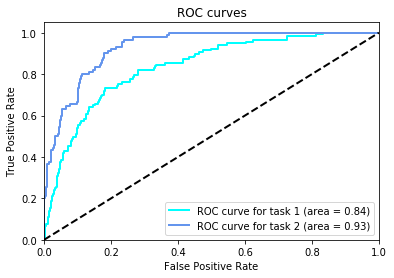

Category 1 Score: 0.836
Category 2 Score: 0.930
Category 3 Score: 0.883


In [33]:
# compute ROC AUC
plot_roc_auc(labels, predictions)

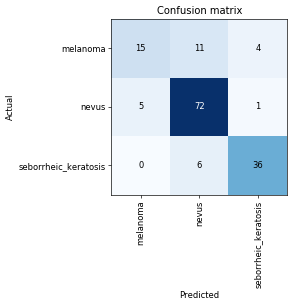

In [34]:
interp = ClassificationInterpretation.from_learner(learn101)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

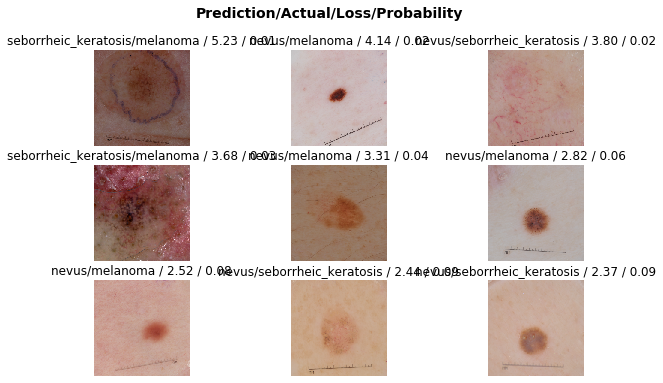

In [35]:
interp.plot_top_losses(9, figsize=(10, 6))